# Home assignment: Что? Где? Когда?

In [381]:
from collections import defaultdict
from datetime import (
    timedelta,
    datetime
)
import pickle
import requests

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression

from scipy import sparse
from scipy.special import expit as sigmoid
import scipy.stats as sps

__Task #1__

Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:

- взять в тренировочный набор турниры с dateStart из 2019 года;
- в тестовый — турниры с dateStart из 2020 года.

In [300]:
tournaments = pickle.load(open('data/tournaments.pkl', 'rb'))
results = pickle.load(open('data/results.pkl', 'rb'))
players = pickle.load(open('data/players.pkl', 'rb'))

In [3]:
TRAIN_YEAR = 2019
TEST_YEAR = 2020

In [4]:
df_tournaments = pd.DataFrame.from_dict(tournaments, orient="index")

# process dates:
for date_col in ['dateStart', 'dateEnd']:
    df_tournaments[date_col] = df_tournaments[date_col].apply(
        lambda x: datetime.fromisoformat(x).replace(tzinfo=None)
    )
# delete all but relevant years:
df_tournaments = df_tournaments.loc[df_tournaments.dateStart.dt.year.isin([TRAIN_YEAR, TEST_YEAR]), :]

In [5]:
# get minimum amount of data for each tournament / team / player
tournaments = list()
for tournament_id, date_start in df_tournaments[['id', 'dateStart']].values:
    
    if tournament_id not in results or len(results[tournament_id]) == 0:
        continue
        
    tournament_data = {
        "id": tournament_id,
        "year": date_start.year,
        "teams": list(),
    }
    
    for team in results[tournament_id]:
        
        team_mask = team.get("mask")
        if team_mask is None or len(team_mask.replace("0", "").replace("1", "")) > 0:
            continue

        cnt_questions = len(team_mask)
        team_id = team['team']['id']
        team_members = list()
        
        for player in team['teamMembers']:
            player_id = player['player']['id']
            team_members.append(player_id)
            
        team_data = {
            "id": team_id,
            "cnt_questions": cnt_questions,
            "mask": team_mask,
            "team_members": team_members
        }
        
        tournament_data["teams"].append(team_data)
        
    tournaments.append(tournament_data)

In [6]:
df_tournaments_processed = pd.DataFrame(tournaments)

# only tournaments with at least one team:
df_tournaments_processed = df_tournaments_processed.loc[
    ~(df_tournaments_processed['teams'].apply(len) == 0), :
]

# delete tournaments with different number of cnt_questions among teams:
df_tournaments_processed['cnt_questions'] = df_tournaments_processed['teams'].apply(
    lambda x: set([i.get('cnt_questions') for i in x])
)
df_tournaments_processed = df_tournaments_processed.loc[
    df_tournaments_processed['cnt_questions'].apply(len) == 1, :
]
df_tournaments_processed['cnt_questions'] = df_tournaments_processed['cnt_questions'].apply(
    lambda x: list(x)[0]
)
df_tournaments_processed['teams'] = df_tournaments_processed['teams'].apply(
    lambda x: [i for i in x]
)

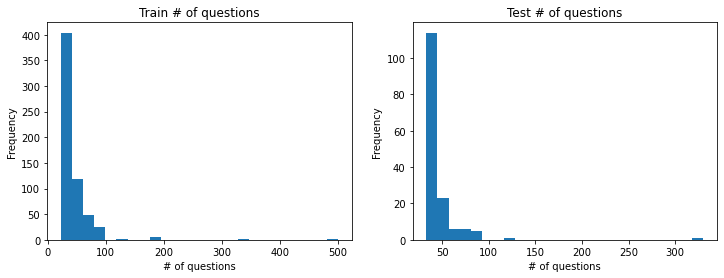

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
df_tournaments_processed \
    .query(f"year == {TRAIN_YEAR}").cnt_questions \
    .plot(kind='hist', bins=25, ax=ax[0], title='Train # of questions')

df_tournaments_processed \
    .query(f"year == {TEST_YEAR}").cnt_questions \
    .plot(kind='hist', bins=25, ax=ax[1], title='Test # of questions')

for ax_i in ax:
    ax_i.set_xlabel("# of questions")

In [8]:
# we could drop tournaments with anomaly number of questions (< 100 would be OK):
df_tournaments_processed = df_tournaments_processed.loc[df_tournaments_processed.cnt_questions < 100, :]

In [9]:
print("Remaining number of tournaments after preprocessing:")
df_tournaments_processed.year.value_counts()

Remaining number of tournaments after preprocessing:


2019    595
2020    154
Name: year, dtype: int64

__Task #2__

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
- повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
- в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
- для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


In [10]:
unique_player_ids = np.unique(
    np.concatenate(
        df_tournaments_processed[
            df_tournaments_processed.year == TRAIN_YEAR
        ].teams.apply(
            lambda x: np.concatenate([team['team_members'] for team in x])
        ).values
    )
).astype(np.int)

print(f"There are {len(unique_player_ids):,d} unique players in TRAIN dataset.")

There are 55,066 unique players in TRAIN dataset.


In [11]:
# preprocessing for further encoding: ladel_id to player_id
player_label_to_id = dict(enumerate(unique_player_ids))
player_id_to_label = {j: i for i, j in player_label_to_id.items()}

In [282]:
player_answers = defaultdict(int)
player_right_answers = defaultdict(int)
player_tours = defaultdict(int)

for tournament_id, year, teams, cnt_questions in df_tournaments_processed[
    df_tournaments_processed.year == TRAIN_YEAR
].values:
    
    tournament_answers = []
    
    for team in teams:
        
        for player_id in team['team_members']:
            
            player_answers[player_id] += len(team['mask'])
            player_right_answers[player_id] = sum(list(map(int, team['mask'])))
            player_tours[player_id] += 1

In [290]:
%%time

player_idxs = []
question_idxs = []
team_ids = []
tournament_ids = []
results = []
player_questions_count = []

questions_count = 0
for tournament_id, year, teams, cnt_questions in df_tournaments_processed[
    df_tournaments_processed.year == TRAIN_YEAR
].values:
    
    for team in teams:
        team_answers = list(map(int, team['mask']))
        
        for q_no in range(cnt_questions):
            
            for player_id in team['team_members']:
                
                player_idxs.append(player_id_to_label[player_id])
                question_idxs.append(len(player_id_to_label) + questions_count + q_no)
                team_ids.append(team['id'])
                tournament_ids.append(tournament_id)
                results.append(team_answers[q_no])
                player_questions_count.append(player_answers[player_id])
    
    questions_count += cnt_questions

# PREPARE TRAIN DATA:
X_train = sparse.lil_matrix(
    (len(player_idxs), len(player_id_to_label) + questions_count),
    dtype=int
)
X_train[range(len(player_idxs)), player_idxs] = 1
X_train[range(len(player_idxs)), question_idxs] = 1
y_train = np.array(results)

CPU times: user 43.8 s, sys: 24.4 s, total: 1min 8s
Wall time: 1min 17s


In [291]:
%%time
# baseline model:
model_lr = LogisticRegression(solver='sag', n_jobs=-1, tol=1e-1, C=8.0)
model_lr.fit(X_train, y_train)

CPU times: user 2min 6s, sys: 483 ms, total: 2min 6s
Wall time: 2min 6s


LogisticRegression(C=8.0, n_jobs=-1, solver='sag', tol=0.1)

In [305]:
# Add predicted rating:
players_rating = model_lr.coef_[0][:len(player_label_to_id)]

df_rating = pd.DataFrame(players_rating, columns=['score']).assign(
    player_label = lambda x: x.index
).assign(
    player_id = lambda x: x.player_label.map(player_label_to_id)
).assign(
    player_name = lambda x: x.player_id.apply(
        lambda x: players[x]['name'] + " " + players[x]['surname']
    )
)

df_rating = df_rating.sort_values(by='score', ascending=False).assign(
    predicted_rating = lambda x: range(len(x))
).reset_index(drop=True)

In [322]:
# actual rating from https://rating.chgk.info/players.php
actual_top_150 = pd.read_csv("./top_150.csv")
actual_top_150['actual_position'] = actual_top_150.actual_position.apply(lambda x: int(x.split(",")[0]))
actual_top_150 = actual_top_150.set_index("player_id").actual_position.to_dict()

In [333]:
# Сколько из текущих ТОП-игроков попали в рейтинг?
df_rating['actual_top150'] = df_rating.player_id.map(actual_top_150)
df_rating.head(150).actual_top150.isna().value_counts()

True     96
False    54
Name: actual_top150, dtype: int64

*Из актуального ТОП-150 игроков 96 оказались в построенном рейтинге, и только 54 в него не попали.*

In [336]:
df_rating.head(10)

,score,player_label,player_id,player_name,predicted_rating,actual_top150
0,4.946366,3696,26798,Анна Резникова,0,NaN
1,4.431584,3767,27403,Максим Руссо,1,5.0
2,4.269867,585,4270,Александра Брутер,2,6.0
3,4.225379,3953,28751,Иван Семушин,3,3.0
4,4.199392,2647,19060,Александр Людикайнен,4,NaN
5,4.174223,3837,27822,Михаил Савченков,5,3.0
6,4.101294,4157,30270,Сергей Спешков,6,3.0
7,4.089315,4137,30152,Артём Сорожкин,7,1.0
8,4.068605,5426,40411,Дмитрий Кудинов,8,NaN
9,3.986688,2506,18036,Михаил Левандовский,9,8.0


__Task #3__

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
- предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
- в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью,
1 усреднённые по тестовому множеству турниров .


In [346]:
df_tournaments_processed.head(2)

,id,year,teams,cnt_questions
0,4772,2019,"[{'id': 45556, 'cnt_questions': 36, 'mask': '1...",36
2,4973,2019,"[{'id': 45556, 'cnt_questions': 36, 'mask': '1...",36


- Соберем рейтинг турниров по тестовой выборке, удалив тех игроков, которые не попали в обучающую выборку

In [345]:
tournaments_test = []
tournaments_rating_actual = []

for tournament_id, year, teams, cnt_questions in df_tournaments_processed[
    df_tournaments_processed.year == TEST_YEAR
].values:
    
    teams_test = []
    teams_rating = []
    
    for team in teams:
        # remove players not from train sample:
        players_filtered = [p for p in team['team_members'] if p in player_id_to_label]
        team['team_members'] = players_filtered
        
        team_mask = team['mask']

        if len(players_filtered) > 0:
            teams_test.append(team)
            team_answers = list(map(int, team_mask))
            teams_rating.append(sum(team_answers))
    
    # only tournaments with at least two teams
    if len(teams_test) > 1:
        tournament_data = {
            "id": tournament_id,
            "cnt_questions": cnt_questions
        }
        tournament_data['teams'] = teams_test
        tournaments_test.append(tournament_data)
        tournaments_rating_actual.append(teams_rating)

- Команда ответит на вопрос, если хотя бы один из участников команды ответит на этот вопрос:
$$P\big(team\_answer = 1\big) = 1 - \prod P\big(player\_answer = 0\big)$$

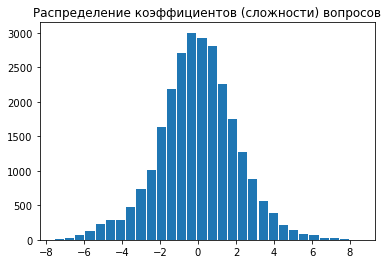

In [359]:
questions_rating = model_lr.coef_[0][len(player_label_to_id):]
plt.title("Распределение коэффициентов (сложности) вопросов")
plt.hist(questions_rating, rwidth=0.9, bins=30);

- Вероятность выиграть турнир для команды будем оценивать как вероятность ответить на один случайно взятый вопрос.

In [372]:
# predict team ratings for each team from test set:
tournaments_rating_predicted = []

for torunament in tournaments_test:
    cnt_questions = torunament['cnt_questions']
    predictions = []
    
    for team in torunament['teams']:
        player_labels = [player_id_to_label[i] for i in team['team_members']]
        cnt_players = len(player_labels)

        X_test = sparse.lil_matrix((cnt_players, X_train.shape[1]), dtype=int)
        X_test[range(cnt_players), player_labels] = 1

        zero_proba = model_lr.predict_proba(X_test)[:, 0]
        team_proba = 1 - zero_proba.prod() 
        predictions.append(team_proba)

    tournaments_rating_predicted.append(predictions)

In [385]:
assert len(tournaments_rating_actual) == len(tournaments_rating_predicted)

- Корреляции предсказанного рейтинга с реальным будем считать по каждому турниру и затем усреднять

In [386]:
spearmanr_corrs = []
kendall_corrs = []

for y_true, y_hat in zip(tournaments_rating_actual, tournaments_rating_predicted):
    spearman = sps.spearmanr(y_true, y_hat).correlation
    kendall = sps.kendalltau(y_true, y_hat).correlation
    spearmanr_corrs.append(spearman)
    kendall_corrs.append(kendall)

print(f'Корреляция Спирмена: {np.mean(spearmanr_corrs):.3f}')
print(f'Корреляция Кендалла: {np.mean(kendall_corrs):.3f}')

Корреляция Спирмена: 0.804
Корреляция Кендалла: 0.646


__Task #4__

Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
- предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
- разработайте EM-схему для обучения этой модели, реализуйте её в коде;
- обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.

__Task #5__

А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).